In [67]:
# Standard Library Imports
import os
import time
import datetime
# Image Processing Libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Machine Learning and Deep Learning Frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Machine Learning Utilities
from sklearn.model_selection import train_test_split

# Image Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Visualization and Logging
import wandb
from tqdm import tqdm
from IPython.display import display, clear_output

In [68]:
# Check PyTorch Version
print(f"PyTorch version: {torch.__version__}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved augmentation pipeline for training
transform = A.Compose([
    A.Resize(height=256, width=256),  # Increased resolution
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),
        A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.5),
    ], p=0.3),
    A.OneOf([
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),  # Reduced variance and probability
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    ], p=0.2),
    A.OneOf([
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
        A.Blur(blur_limit=3, p=0.5),
        A.MedianBlur(blur_limit=3, p=0.5),
    ], p=0.3),
    ToTensorV2(),
])

# Simplified test/validation transform
transform_test = A.Compose([
    A.Resize(height=256, width=256), 
    ToTensorV2(),
])

# Prediction transform matching training resolution
predict_transform = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])

PyTorch version: 2.4.0
Using device: cuda


In [69]:
class KidneyDataset(Dataset):
    def __init__(self, filenames, image_dir, masks_dir, transform=None):
        """
        Initialize the Kidney Dataset.
        
        Args:
            filenames (list): List of image filenames
            image_dir (str): Directory containing images
            masks_dir (str): Directory containing mask images
            transform (callable, optional): Optional image transformations
        """
        self.filenames = filenames
        self.image_dir = image_dir
        self.masks_dir = masks_dir
        self.transform = transform
    
    def __len__(self):
        """
        Return the total number of images in the dataset.
        
        Returns:
            int: Number of images
        """
        return len(self.filenames)
    
    def __getitem__(self, idx):
        """
        Retrieve a single image and its corresponding mask.
        
        Args:
            idx (int): Index of the image to retrieve
        
        Returns:
            tuple: Processed image and mask tensors
        """
        # Construct full paths for image and mask
        img_path = os.path.join(self.image_dir, self.filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.filenames[idx])
        
        # Read images in grayscale and normalize
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        
        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Ensure image and mask are torch tensors
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image)
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        
        # Add channel dimension if needed
        if len(image.shape) == 2:
            image = image.unsqueeze(0)
        if len(mask.shape) == 2:
            mask = mask.unsqueeze(0)
        
        return image, mask

In [70]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        """
        Focal Loss implementation.
        
        Args:
            alpha (float): Balancing parameter. Default is 0.8.
            gamma (float): Focusing parameter. Default is 2.0.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        """
        Compute Focal Loss.
        
        Args:
            inputs (torch.Tensor): Predicted logits
            targets (torch.Tensor): Target labels
        
        Returns:
            torch.Tensor: Computed Focal Loss
        """
        # Compute binary cross-entropy loss
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # Compute probability of the ground truth class
        pt = torch.exp(-bce_loss)
        
        # Compute Focal Loss
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        
        return focal_loss.mean()

In [71]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Residual Block with convolutional layers and batch normalization.
        
        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels
        """
        super(ResidualBlock, self).__init__()
        
        # Convolutional block with batch normalization and ReLU
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # Residual connection to handle channel and dimension changes
        self.residual = ResidualConnection(in_channels, out_channels)
        
    def forward(self, x):
        """
        Forward pass of the Residual Block.
        
        Args:
            x (torch.Tensor): Input tensor
        
        Returns:
            torch.Tensor: Output tensor after residual connection
        """
        # Store the input as the identity for the residual connection
        identity = x
        
        # Pass input through convolutional block
        x = self.conv_block(x)
        
        # Apply residual connection
        return self.residual(x, identity)

In [72]:
class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        """
        Enhanced UNet with Residual Blocks, Deep Supervision, and Layer Normalization.
        
        Args:
            in_channels (int): Number of input channels. Default is 1 (grayscale).
            out_channels (int): Number of output channels. Default is 1 (binary segmentation).
        """
        super(EnhancedUNet, self).__init__()
        
        # Encoder with Residual Blocks
        self.encoder1 = ResidualBlock(in_channels, 64)
        self.encoder2 = ResidualBlock(64, 128)
        self.encoder3 = ResidualBlock(128, 256)
        self.encoder4 = ResidualBlock(256, 512)
        self.encoder5 = ResidualBlock(512, 1024)
        
        # Deep Supervision Convolutions
        self.deep_sup4 = nn.Conv2d(512, out_channels, 1)
        self.deep_sup3 = nn.Conv2d(256, out_channels, 1)
        self.deep_sup2 = nn.Conv2d(128, out_channels, 1)
        
        # Decoder Upconvolution and Normalization
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = ResidualBlock(1024, 512)
        self.norm4 = nn.LayerNorm([512, 32, 32])
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = ResidualBlock(512, 256)
        self.norm3 = nn.LayerNorm([256, 64, 64])
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = ResidualBlock(256, 128)
        self.norm2 = nn.LayerNorm([128, 128, 128])
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = ResidualBlock(128, 64)
        self.norm1 = nn.LayerNorm([64, 256, 256])
        
        # Final Convolution and Dropout
        self.final_conv = nn.Conv2d(64, out_channels, 1)
        self.dropout = nn.Dropout2d(0.3)
    
    def forward(self, x):
        """
        Forward pass of the Enhanced UNet.
        
        Args:
            x (torch.Tensor): Input tensor
        
        Returns:
            Tensor or tuple: Final output, and deep supervision outputs if in training mode
        """
        # Encoder path with dropout
        enc1 = self.dropout(self.encoder1(x))
        enc2 = self.dropout(self.encoder2(F.max_pool2d(enc1, 2)))
        enc3 = self.dropout(self.encoder3(F.max_pool2d(enc2, 2)))
        enc4 = self.dropout(self.encoder4(F.max_pool2d(enc3, 2)))
        enc5 = self.dropout(self.encoder5(F.max_pool2d(enc4, 2)))
        
        # Decoder path with deep supervision
        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.norm4(self.decoder4(dec4))
        deep_out4 = self.deep_sup4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.norm3(self.decoder3(dec3))
        deep_out3 = self.deep_sup3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.norm2(self.decoder2(dec2))
        deep_out2 = self.deep_sup2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.norm1(self.decoder1(dec1))
        
        final_out = self.final_conv(dec1)
        
        # Return different outputs based on training mode
        return (final_out, deep_out4, deep_out3, deep_out2) if self.training else final_out

In [73]:
class ResidualConnection(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Residual Connection module to handle channel and dimension adjustments.
        
        Args:
            in_channels (int): Number of input channels
            out_channels (int): Number of output channels
        """
        super(ResidualConnection, self).__init__()
        
        # Create a 1x1 convolution if channel dimensions differ
        self.conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else None
    
    def forward(self, x, identity):
        """
        Forward pass of the Residual Connection.
        
        Args:
            x (torch.Tensor): Main input tensor
            identity (torch.Tensor): Residual/skip connection input tensor
        
        Returns:
            torch.Tensor: Tensor after adding main input and adjusted identity
        """
        # Adjust identity tensor's channels if needed
        if self.conv is not None:
            identity = self.conv(identity)
        
        # Add the main input and identity
        return x + identity

In [74]:
class AttentionBlock(nn.Module):
    """
    An Attention Block implementation for neural networks, 
    typically used in architectures like U-Net for feature refinement.
    
    The block applies attention mechanisms to refine feature representations
    by learning to emphasize important features and suppress less relevant ones.
    """
    def __init__(self, F_g, F_l=None, F_int=None):
        """
        Initialize the Attention Block.
        
        Args:
            F_g (int): Number of feature channels in the gate input
            F_l (int, optional): Number of feature channels in the layer input. 
                                 Defaults to same as F_g if not specified.
            F_int (int, optional): Number of intermediate feature channels. 
                                   Defaults to half of F_g if not specified.
        """
        super(AttentionBlock, self).__init__()
        
        # Set default values if not provided
        if F_l is None:
            F_l = F_g
        if F_int is None:
            F_int = F_g // 2
        
        # Gate convolution: transforms gate input to intermediate feature space
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Layer convolution: transforms layer input to intermediate feature space
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Attention mechanism: generates attention weights
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        # Activation function
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x=None):
        """
        Forward pass of the Attention Block.
        
        Args:
            g (Tensor): Gate input tensor
            x (Tensor, optional): Layer input tensor. 
                                  Defaults to the gate input if not specified.
        
        Returns:
            Tensor: Refined feature representation
        """
        # If no layer input is provided, use gate input
        if x is None:
            x = g
        
        # Transform gate and layer inputs to intermediate feature space
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        # Combine and apply non-linearity
        psi = self.relu(g1 + x1)
        
        # Generate attention weights
        psi = self.psi(psi)
        
        # Apply attention weights to input
        return x * psi

In [75]:
def train_model(model, dataloaders, criterion=None, optimizer=None, scheduler=None, 
                num_epochs=2, accumulation_steps=2, mixed_precision=True):
    """
    Advanced training function with multiple features:
    - Mixed precision training
    - Gradient accumulation
    - Deep supervision loss
    - Early stopping
    - Wandb experiment tracking
    - Performance metrics tracking

    Args:
        model (nn.Module): Neural network model to train
        dataloaders (dict): Dictionary containing 'train' and 'val' dataloaders
        criterion (nn.Module, optional): Loss function. Defaults to Focal Loss.
        optimizer (torch.optim, optional): Optimizer. Defaults to AdamW.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. 
        num_epochs (int): Total number of training epochs
        accumulation_steps (int): Gradient accumulation steps
        mixed_precision (bool): Enable mixed precision training
    """
    # Device and initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_loss = float('inf')
    train_losses, val_losses = [], []
    
    # Initialize defaults if not provided
    if criterion is None:
        criterion = FocalLoss(alpha=0.8, gamma=2.0)
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    if scheduler is None:
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training configuration
    patience = 10
    patience_counter = 0
    clip_value = 1.0
    scaler = GradScaler() if mixed_precision else None
    
    # Experiment tracking
    wandb.init(project="kidney-segmentation", config={
        "epochs": num_epochs,
        "batch_size": dataloaders['train'].batch_size,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "architecture": model.__class__.__name__,
        "criterion": type(criterion).__name__,
        "clip_value": clip_value,
        "patience": patience
    })
    
    # Deterministic settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            
            running_loss = running_precision = running_recall = 0.0
            optimizer.zero_grad()
            
            pbar = tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch+1}')
            for i, (inputs, masks) in enumerate(pbar):
                inputs, masks = inputs.to(device), masks.to(device)
                
                with autocast(enabled=mixed_precision):
                    # Handle deep supervision for training phase
                    if phase == 'train':
                        outputs, deep4, deep3, deep2 = model(inputs)
                        main_loss = criterion(outputs, masks)
                        aux_loss4 = criterion(F.interpolate(deep4, size=masks.shape[2:]), masks)
                        aux_loss3 = criterion(F.interpolate(deep3, size=masks.shape[2:]), masks)
                        aux_loss2 = criterion(F.interpolate(deep2, size=masks.shape[2:]), masks)
                        loss = (main_loss + 0.4 * aux_loss4 + 0.2 * aux_loss3 + 0.1 * aux_loss2) / accumulation_steps
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, masks) / accumulation_steps
                
                # Gradient handling and optimization
                if phase == 'train':
                    if mixed_precision:
                        scaler.scale(loss).backward()
                        if (i + 1) % accumulation_steps == 0:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                            scaler.step(optimizer)
                            scaler.update()
                            optimizer.zero_grad()
                    else:
                        loss.backward()
                        if (i + 1) % accumulation_steps == 0:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                            optimizer.step()
                            optimizer.zero_grad()
                
                # Calculate metrics
                with torch.no_grad():
                    pred_masks = (torch.sigmoid(outputs) > 0.5).float()
                    true_positives = (pred_masks * masks).sum()
                    precision = true_positives / (pred_masks.sum() + 1e-8)
                    recall = true_positives / (masks.sum() + 1e-8)
                    
                    running_loss += loss.item() * accumulation_steps * inputs.size(0)
                    running_precision += precision.item()
                    running_recall += recall.item()
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': loss.item(),
                    'precision': precision.item(),
                    'recall': recall.item()
                })
            
            # Epoch-level calculations
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_precision = running_precision / len(dataloaders[phase])
            epoch_recall = running_recall / len(dataloaders[phase])
            
            print(f'{phase} Loss: {epoch_loss:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}')
            
            # Logging and tracking
            wandb.log({
                f"{phase}_loss": epoch_loss,
                f"{phase}_precision": epoch_precision,
                f"{phase}_recall": epoch_recall
            }, step=epoch)
            
            # Update losses and scheduler
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
                
                # Early stopping and model checkpoint
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    patience_counter = 0
                    print("Best model saved")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_loss,
                        'precision': epoch_precision,
                        'recall': epoch_recall
                    }, 'best_model_checkpoint.pth')
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f'Early stopping triggered at epoch {epoch+1}')
                        wandb.finish()
                        return model, train_losses, val_losses
    
    # Write training details
    with open('/kaggle/working/training_details.txt', 'w') as f:
        details = [
            f"Number of epochs: {num_epochs}",
            f"Best validation loss: {best_loss:.4f}",
            f"Final training loss: {train_losses[-1]:.4f}",
            f"Final validation loss: {val_losses[-1]:.4f}",
            f"Learning rate: {optimizer.param_groups[0]['lr']}",
            f"Optimizer: {type(optimizer).__name__}",
            f"Scheduler: {type(scheduler).__name__}",
            f"Loss function: {type(criterion).__name__}",
            f"Model architecture: {type(model).__name__}"
        ]
        f.write("\n".join(details))
    
    wandb.finish()
    return model, train_losses, val_losses

In [76]:
def calculate_metrics(pred_mask, true_mask):
    """
    Calculate various performance metrics for a segmentation model.
    
    Args:
        pred_mask (tensor): Predicted segmentation mask
        true_mask (tensor): Ground truth segmentation mask
    
    Returns:
        dict: Performance metrics including Dice coefficient, IoU, precision, and recall
    """
    dice = dice_coefficient(pred_mask, true_mask)
    iou = intersection_over_union(pred_mask, true_mask)
    precision = precision_score(pred_mask, true_mask)
    recall = recall_score(pred_mask, true_mask)
    
    return {
        'dice': dice,
        'iou': iou,
        'precision': precision,
        'recall': recall
    }

def evaluate_model_metrics(model, dataloaders, num_samples=12, save_dir='/kaggle/working'):
    """
    Evaluate a segmentation model's performance and visualize results.
    
    Args:
        model (nn.Module): Trained segmentation model
        dataloaders (dict/DataLoader): Test data loader
        num_samples (int, optional): Number of samples to visualize. Defaults to 12.
        save_dir (str, optional): Directory to save visualization results. Defaults to '/kaggle/working'.
    
    Returns:
        tuple: Mean Dice score, mean IoU score, and mean confidence score
    """
    model.eval()
    dice_scores = []
    iou_scores = []
    confidence_scores = []
    
    os.makedirs(save_dir, exist_ok=True)
    
    all_images = []
    all_masks = []
    all_predictions = []
    all_confidences = []
    
    # Select the appropriate test loader
    test_loader = dataloaders['test2'] if isinstance(dataloaders, dict) else dataloaders
    
    with torch.no_grad():
        for batch in test_loader:
            images, masks = batch[:2]
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass and prediction
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predicted = probabilities > 0.5
            
            # Collect results for visualization and metric calculation
            all_images.extend(images.cpu())
            all_masks.extend(masks.cpu())
            all_predictions.extend(predicted.cpu())
            all_confidences.extend(probabilities.cpu())
            
            # Calculate Dice score
            intersection = (predicted & masks.bool()).float().sum((1, 2, 3))
            union = predicted.float().sum((1, 2, 3)) + masks.float().sum((1, 2, 3))
            dice = (2 * intersection) / (union + 1e-7)
            dice_scores.extend(dice.cpu().numpy())
            
            # Calculate Intersection over Union (IoU)
            union = (predicted | masks.bool()).float().sum((1, 2, 3))
            iou = intersection / (union + 1e-7)
            iou_scores.extend(iou.cpu().numpy())
            
            # Calculate confidence scores
            confidence_scores.extend(probabilities.mean((1, 2, 3)).cpu().numpy())
    
    # Randomly select samples for visualization
    num_total_samples = len(all_images)
    selected_indices = random.sample(range(num_total_samples), min(num_samples, num_total_samples))
    
    # Split selected indices into groups of 4 for saving
    num_groups = (len(selected_indices) + 3) // 4
    for group_idx in range(num_groups):
        fig, axes = plt.subplots(4, 5, figsize=(25, 20))
        fig.suptitle("Comparison of True Masks and Predicted Masks", fontsize=16)
        
        for idx in range(4):
            sample_idx = group_idx * 4 + idx
            if sample_idx >= len(selected_indices):
                break
            
            # Retrieve sample data
            img_idx = selected_indices[sample_idx]
            image = all_images[img_idx].squeeze().numpy()
            true_mask = all_masks[img_idx].squeeze().numpy()
            pred_mask = all_predictions[img_idx].squeeze().numpy()
            confidence = all_confidences[img_idx].squeeze().numpy()
            
            # Original image
            axes[idx, 0].imshow(image, cmap='gray')
            axes[idx, 0].set_title(f'Original Image {sample_idx + 1}')
            axes[idx, 0].axis('off')
            
            # True mask
            axes[idx, 1].imshow(true_mask, cmap='gray')
            axes[idx, 1].set_title(f'True Mask {sample_idx + 1}')
            axes[idx, 1].axis('off')
            
            # Predicted mask (yellow)
            yellow_mask = np.zeros((*pred_mask.shape, 3))
            yellow_mask[pred_mask > 0.5] = [1, 1, 0]  # Yellow color
            axes[idx, 2].imshow(yellow_mask)
            axes[idx, 2].set_title(f'Predicted Mask {sample_idx + 1}\nConfidence: {confidence.mean():.2f}')
            axes[idx, 2].axis('off')
            
            # True mask overlay
            true_overlay = np.stack((image,)*3, axis=-1)
            true_mask_rgb = np.zeros((*true_mask.shape, 3))
            true_mask_rgb[true_mask > 0.5] = [1, 0, 0]  # Red color for true mask
            true_overlay = true_overlay * 0.7 + true_mask_rgb * 0.3
            axes[idx, 3].imshow(true_overlay)
            axes[idx, 3].set_title(f'True Mask Overlay {sample_idx + 1}')
            axes[idx, 3].axis('off')
            
            # Predicted mask overlay
            pred_overlay = np.stack((image,)*3, axis=-1)
            pred_mask_rgb = np.zeros((*pred_mask.shape, 3))
            pred_mask_rgb[pred_mask > 0.5] = [1, 1, 0]  # Yellow color for predicted mask
            pred_overlay = pred_overlay * 0.7 + pred_mask_rgb * 0.3
            axes[idx, 4].imshow(pred_overlay)
            axes[idx, 4].set_title(f'Predicted Mask Overlay {sample_idx + 1}')
            axes[idx, 4].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/mask_comparison_split_{group_idx + 1}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # Calculate and save metrics
    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    mean_confidence = np.mean(confidence_scores)
    
    with open(f'{save_dir}/metrics.txt', 'w') as f:
        f.write(f'Mean Dice Score: {mean_dice:.4f}\n')
        f.write(f'Mean IoU Score: {mean_iou:.4f}\n')
        f.write(f'Mean Confidence Score: {mean_confidence:.4f}\n')
    
    print(f"Results saved to {save_dir}/mask_comparison_split_*.png")
    print(f"Metrics saved to {save_dir}/metrics.txt")
    
    return mean_dice, mean_iou, mean_confidence

In [77]:
def save_model(model, path):
    # Save the model's state dictionary to the specified path
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [78]:
def load_model(model_path):
    # Initialize the ImprovedUNet model and load its state dictionary
    model = ImprovedUNet(in_channels=1, out_channels=1)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

In [79]:
class PostProcessor:
    def __init__(self, min_component_size=100, confidence_threshold=0.5):
        # Initialize post-processing parameters
        self.min_component_size = min_component_size
        self.confidence_threshold = confidence_threshold
    
    def process(self, pred_mask):
        # Apply confidence thresholding
        binary_mask = (pred_mask > self.confidence_threshold).astype(np.uint8)
        
        # Label connected components
        labeled_mask, num_features = ndimage.label(binary_mask)
        
        # Filter small components
        for i in range(1, num_features + 1):
            component_size = (labeled_mask == i).sum()
            if component_size < self.min_component_size:
                binary_mask[labeled_mask == i] = 0
        
        return binary_mask

In [89]:
class KidneyEvaluator:
    def __init__(self, model_path, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(model_path)
        self.model.eval()
        
    def load_model(self, model_path):
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
        model = EnhancedUNet(in_channels=1, out_channels=1)
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total number of parameters: {total_params}")
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(self.device)
        return model
    
    def preprocess_image(self, image):
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize to model input size
        image = cv2.resize(image, (256, 256))
        
        # Normalize and convert to tensor
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
        return image.to(self.device)
    
    def process_single_image(self, image_path, save_path=None):
        # Read image
        original = cv2.imread(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Store original dimensions
        original_height, original_width = original.shape[:2]
        
        # Preprocess
        start_time = datetime.datetime.now()
        processed = self.preprocess_image(image)
        
        # Inference
        with torch.no_grad():
            output = self.model(processed)
            probabilities = torch.sigmoid(output)
            prediction = (probabilities > 0.5).float()
        end_time = datetime.datetime.now()
        inference_time = end_time - start_time
        
        # Convert predictions back to numpy and resize to original dimensions
        pred_mask = prediction.squeeze().cpu().numpy()
        conf_map = probabilities.squeeze().cpu().numpy()
        
        # Resize predictions to match original image dimensions
        pred_mask = cv2.resize(pred_mask, (original_width, original_height))
        conf_map = cv2.resize(conf_map, (original_width, original_height))
        
        confidence_score = float(conf_map.mean())
        
        # Create visualization
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Inference Time: {inference_time}s')
        
        # Original
        axes[0, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Predicted Mask
        axes[0, 1].imshow(pred_mask, cmap='gray')
        axes[0, 1].set_title('Predicted Mask')
        axes[0, 1].axis('off')
        
        # Confidence Map
        conf_map_display = axes[0, 2].imshow(conf_map, cmap='jet')
        axes[0, 2].set_title('Confidence Map')
        axes[0, 2].axis('off')
        plt.colorbar(conf_map_display, ax=axes[0, 2])
        
        # Overlay
        overlay = cv2.cvtColor(original, cv2.COLOR_BGR2RGB).copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[pred_mask > 0.5] = [255, 255, 0]  # Yellow overlay
        overlay = cv2.addWeighted(overlay, 0.9, mask_overlay, 0.15, 0)   # Yellow overlay
        axes[1, 0].imshow(overlay)
        axes[1, 0].set_title('Mask Overlay')
        axes[1, 0].axis('off')
        
        # Empty plots for symmetry
        axes[1, 1].axis('off')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        
        # Save figure if save_path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        end_time2 = datetime.datetime.now()
        inference_time2 = end_time2 - start_time
        print(start_time, end_time2, inference_time2)
        
        return {
            'original': original,
            'pred_mask': pred_mask,
            'conf_map': conf_map,
            'inference_time': inference_time,
            'figure': fig  # Keep the figure for potential further use
        }
    
    def save_result_image(self, result, save_path):
        """
        Save the result visualization to a specified path.
        
        Args:
            result (dict): The dictionary returned by process_single_image
            save_path (str): Path where the image should be saved
        """
        if result['figure'] is not None:
            result['figure'].savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close(result['figure'])  # Close the figure to free memory
        else:
            print("No figure available to save.")

In [90]:

def evaluate_dataset(model_path, image_dir, output_dir):
    """Evaluate a directory of images and save results"""
    evaluator = KidneyEvaluator(model_path)
    os.makedirs(output_dir, exist_ok=True)
    
    results = []
    
    for img_name in tqdm(image_dir):
            img_path=os.path.join("/kaggle/input/2kdataset/2kdataset/images",img_name)
        
            result = evaluator.process_single_image(img_path)
            
            # Save visualization
            result['figure'].savefig(os.path.join(output_dir, f'eval_{img_name}'))
            plt.close(result['figure'])
            
            results.append({
                'image': img_name,
                'inference_time': result['inference_time']
            })
    
    # Save summary
    with open(os.path.join(output_dir, 'evaluation_summary.txt'), 'w') as f:
        f.write('Image Evaluation Summary\n')
        f.write('======================\n\n')
        for result in results:
            f.write(f"Image: {result['image']}\n")
            f.write(f"Confidence: {result['confidence']:.3f}\n")
            f.write(f"Inference Time: {result['inference_time']:.3f}s\n\n")

In [91]:
def main():
    # Paths
    images_dir = '/kaggle/input/2kdataset/2kdataset/images'  # Update with your actual path
    masks_dir = '/kaggle/input/2kdataset/2kdataset/masks'    # Update with your actual path
    
    # Ensure directories exist
    assert os.path.exists(images_dir), f"Images directory not found: {images_dir}"
    assert os.path.exists(masks_dir), f"Masks directory not found: {masks_dir}"
    
    # Get filenames and split dataset
    image_filenames = os.listdir(images_dir)
    train_filenames, val_test_filenames = train_test_split(image_filenames, test_size=0.3, random_state=42)
    val_filenames, test_filenames = train_test_split(val_test_filenames, test_size=0.5, random_state=42)
    
    # Create datasets
    train_dataset = KidneyDataset(train_filenames, images_dir, masks_dir, transform=transform)
    val_dataset = KidneyDataset(val_filenames, images_dir, masks_dir, transform=transform)
    test_dataset = KidneyDataset(test_filenames, images_dir, masks_dir, transform=transform)
    test_dataset2 = KidneyDataset(test_filenames, images_dir, masks_dir, transform=transform_test2)
    
    # Debug: Check shapes
    sample_image, sample_mask = train_dataset[0]
    print(f"Sample image shape: {sample_image.shape}")
    print(f"Sample mask shape: {sample_mask.shape}")
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    test_loader2 = DataLoader(test_dataset2, batch_size=16, shuffle=False)
    
    # Debug: Check batch shapes
    for batch_images, batch_masks in train_loader:
        print(f"Batch image shape: {batch_images.shape}")
        print(f"Batch mask shape: {batch_masks.shape}")
        break
    
    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    
    dataloaders2 = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader,
        'test2': test_loader2
    }
    
    # Initialize model, criterion, and optimizer
    model = EnhancedUNet(in_channels=1, out_channels=1).to(device)
    criterion = FocalLoss(alpha=0.8, gamma=2.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=2)
    
    # Train model
    print("Starting training...")
    model, train_losses, val_losses = train_model(
        model, dataloaders, criterion, optimizer, scheduler,
        num_epochs=150, accumulation_steps=2, mixed_precision=True
    )
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, 'final_model28.pth')

    # Model paths


/tmp/ipykernel_23/2555996502.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))


Total number of parameters: 48167556
2024-12-09 04:36:10.050884 2024-12-09 04:36:11.391732 0:00:01.340848


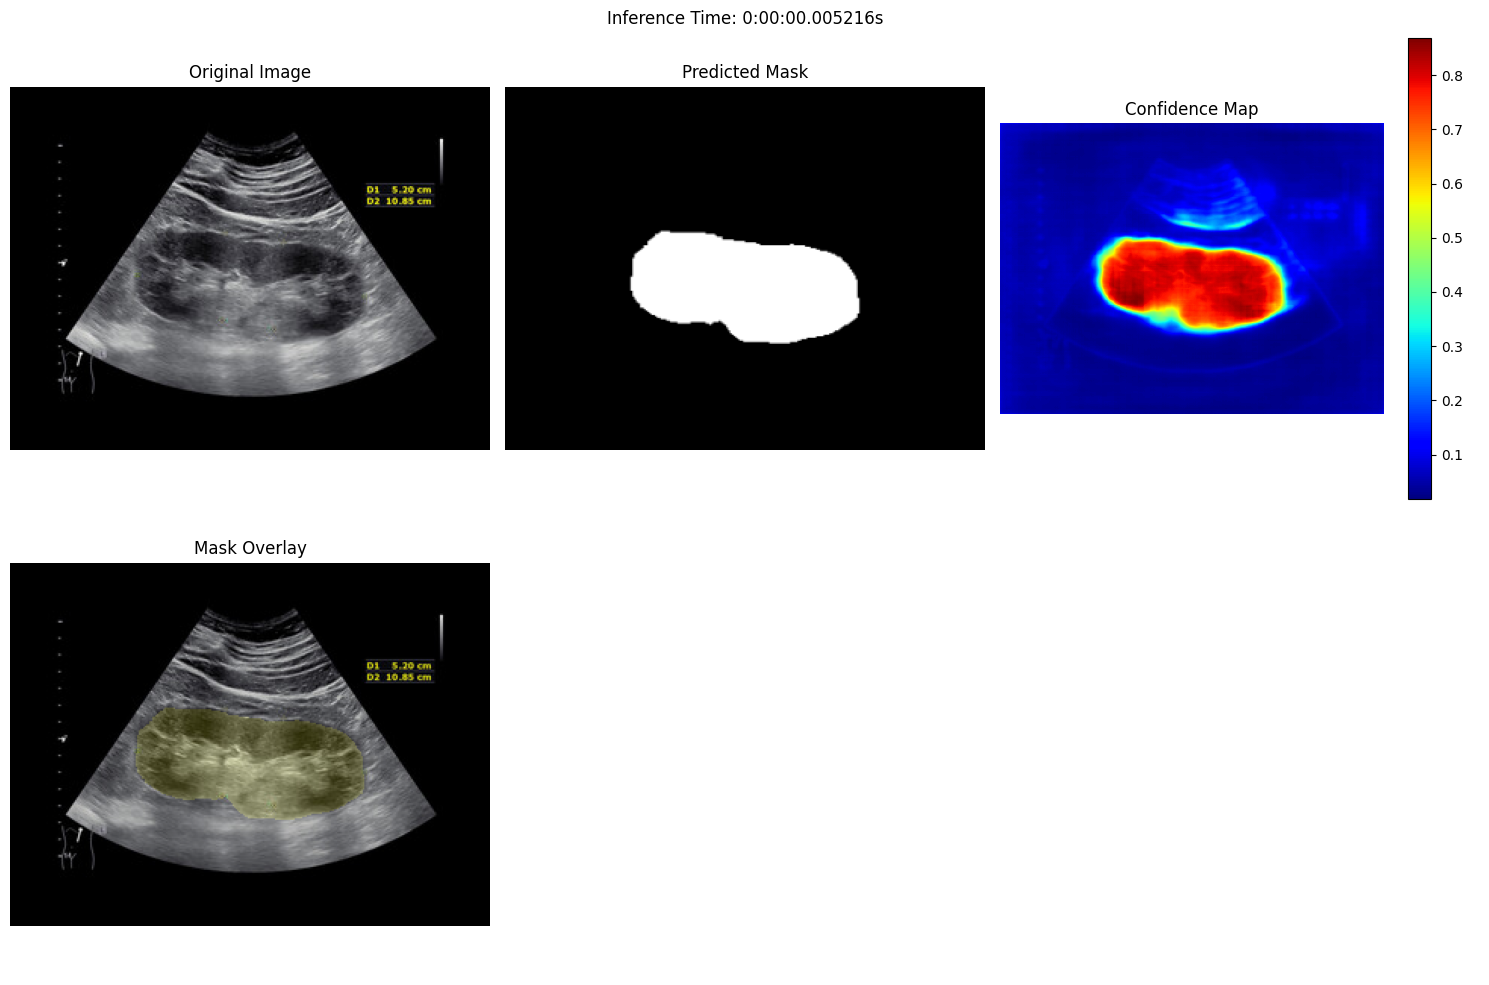

In [117]:
m1 = '/kaggle/input/kidneyseg/pytorch/default/20/final_model28 _1_MW.pth'
m2 = '/kaggle/input/kidneyseg/pytorch/default/20/best_model_checkpoint_1MW.pth'
m3 = '/kaggle/input/kidneyseg/pytorch/default/20/final_model28_MW_2.pth'
m4 = '/kaggle/input/kidneyseg/pytorch/default/20/best_model_checkpoint_MW_2.pth'

# Evaluate single image
evaluator = KidneyEvaluator(m2)
image_path = '/kaggle/input/testimages/240_F_603611028_GGVVOAxWeuRbSFgkZVrcJIkMSLJfeTDG.jpg'

result = evaluator.process_single_image(image_path, save_path='/kaggle/working/kidney_result.png')

